In [4]:
import json
import nxviz as nv
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches
import string

/usr/local/lib/python3.12/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [5]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

In [6]:
def dictdiv(num, denom):
  o = {}
  for i in num:
    o[i] = num[i] / denom[i]

In [7]:
file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

In [9]:
consumption_concentration_eora = pd.read_csv('First_review_data/S8.csv',header=None)

In [10]:
consumption_concentration_eora.columns = list(final_demand_eora.keys())

In [11]:
consumption_concentration_eora = consumption_concentration_eora.astype(float)

In [12]:
countries = [
          'USA', "SAU", "GBR","TUR", # top 4 Net exporters
          "VNM", "BGD", "IND", "CHN", # top 4 net importers
          ]

In [13]:
production_concentration_eora = pd.DataFrame()
for country in countries:
  shp = pd.read_csv('First_review_data/S5/'+str(country)+'.csv',index_col=0)
  production_concentration_eora[country] = shp.sum(axis=1)

In [14]:
production_concentration_eora = production_concentration_eora.astype(float)

In [15]:
cut = 5 # percentile for clipping color scale

diff = np.zeros((consumption_concentration_eora.shape[0], len(countries)))
for i, c in enumerate(countries):
      diff[:, i] = consumption_concentration_eora[c] - production_concentration_eora[c]
cutpt = max(abs(np.percentile(list(diff),cut)), abs(np.percentile(list(diff),100-cut)))

In [16]:
df_shp_eora = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')
robinson = ccrs.Robinson().proj4_init
df_shp_eora = df_shp_eora.to_crs(robinson)

In [17]:
layout = {}
for i, c in enumerate(df_shp_eora.ADM0_A3):
  p = df_shp_eora.centroid[i]
  layout[c] = [p.x, p.y]

In [18]:
# population
file = open("First_review_data/Total_pop_eora.json", "r")
population_eora = file.read()
population_eora = json.loads(population_eora)

In [19]:
con_mort_tol_eora = pd.read_csv('First_review_data/S4.csv',index_col=0)
# Row sum: total deaths happen in that country
con_total_eora = dict(con_mort_tol_eora.sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_eora = dict(con_mort_tol_eora.sum(axis=0))

In [20]:
df_shp_eora.loc[df_shp_eora[df_shp_eora['ADM0_A3']=='SDN'].index,'ADM0_A3'] = 'SUD'
df_shp_eora.loc[df_shp_eora[df_shp_eora['ADM0_A3']=='PSX'].index,'ADM0_A3'] = 'PSE'

In [21]:
# convert csv to dict
nested_dict = {
    col: con_mort_tol_eora[col].to_dict()
    for col in con_mort_tol_eora.columns
}

In [22]:
# Calculate death exports.
# TODO: I'm not sure whether this is the correct way to do this calculation # Yes
# TODO: A lot of countries in africa are missing! # Done
df_shp_eora["death_exports"] = np.nan
df_shp_eora["death_exports_raw"] = np.nan # without clipping
df_shp_eora["death_exports_tol"] = np.nan

df_shp_eora.ADM0_A3

for i, s in enumerate(nested_dict):
  if s != 'ROW':
    totalexp = 0
    for d in nested_dict[s]:
      exp = nested_dict[s][d]  # Number of deaths caused by country s and occurring in country d (export of death of country s)
      inp = nested_dict[d][s]  # Number of deaths occurring in country s and caused by country d (import death of country s)
      netexp = exp - inp
      totalexp += netexp
    ii = df_shp_eora.index[df_shp_eora.ADM0_A3 == s][0]
    df_shp_eora.death_exports_tol[ii] = totalexp
    df_shp_eora.death_exports_raw[ii] = totalexp / population_eora[s] * 1e6
    df_shp_eora.death_exports[ii] = max(min(totalexp / population_eora[s] * 1e6, 600), -500)  # Exported deaths per million people, clipped at 500

/tmp/ipython-input-300254652.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_shp_eora.death_exports_tol[ii] = totalexp
/tmp/ipython-input-300254652.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [23]:
import networkx as nx
G = nx.DiGraph()

for c in population_eora:
  G.add_nodes_from([(c, {"pop": population_eora[c]})])

for s in population_eora:
  for d in population_eora:
    exp = con_mort_tol_eora[s][d]
    imp = con_mort_tol_eora[d][s]
    if exp > imp:
      G.add_edges_from([(s, d, {
          "con_exp_deaths": exp-imp,
          })])

In [24]:
G_df = pd.DataFrame(G.edges.data())
G_df.columns = ['From','To','Values']
G_df['Values'] = [a['con_exp_deaths'] for a in G_df['Values']]

In [25]:
G_df.sort_values(by=['Values'], ascending=False,inplace=True)

In [26]:
unique_countries = set(G_df['To'].unique()).union(set(G_df['From'].unique()))

In [27]:
net_import_ratio = {}
net_export_ratio = {}
for i in unique_countries:
  From = len(G_df[G_df['From'] == i])
  To = len(G_df[G_df['To'] == i])
  all_relationship = From + To
  net_import_ratio[i] = To/all_relationship
  net_export_ratio[i] = From/all_relationship

In [28]:
sorted(net_export_ratio.items(), key=lambda x:x[1],reverse=True)[:13]

[('ISL', 1.0),
 ('VUT', 0.994475138121547),
 ('FJI', 0.994475138121547),
 ('GRL', 0.994475138121547),
 ('VGB', 0.994475138121547),
 ('WSM', 0.994475138121547),
 ('ATG', 0.994475138121547),
 ('NOR', 0.9625668449197861),
 ('IRL', 0.946524064171123),
 ('KWT', 0.9358288770053476),
 ('GUY', 0.9358288770053476),
 ('SMR', 0.9358288770053476),
 ('LIE', 0.9358288770053476)]

In [30]:
sorted(net_import_ratio.items(), key=lambda x:x[1],reverse=True)[:10]

[('ROW', 1.0),
 ('MDA', 0.9946524064171123),
 ('VNM', 0.9786096256684492),
 ('PRK', 0.9786096256684492),
 ('BGD', 0.9679144385026738),
 ('NPL', 0.946524064171123),
 ('IND', 0.9411764705882353),
 ('KHM', 0.9358288770053476),
 ('CHN', 0.9251336898395722),
 ('BGR', 0.9037433155080213)]

In [31]:
G_df.to_csv("First_review_data/S10.csv")

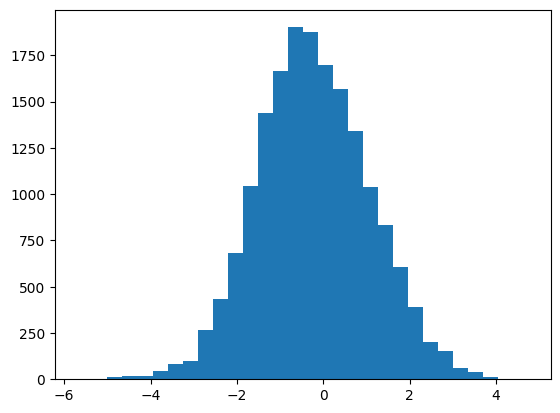

In [32]:
con_exp_deaths = np.zeros(len(G.edges))
ced = nx.get_edge_attributes(G, "con_exp_deaths")
for i, e in enumerate(G.edges):
  con_exp_deaths[i] = ced[e]
plt.hist(np.log10(con_exp_deaths), bins=30);

In [33]:
cut = np.percentile(con_exp_deaths, 99.6)
cut

np.float64(1859.4801961878618)

In [34]:
H = G.copy()
for i, e in enumerate(list(H.edges)):
  if con_exp_deaths[i] < cut: H.remove_edge(e[0], e[1])

for i, n in enumerate(list(H.nodes)):
  if H.degree[n] <= 1: H.remove_node(n)

In [35]:
H.edges

OutEdgeView([('FRA', 'DEU'), ('FRA', 'IND'), ('FRA', 'CHN'), ('USA', 'RUS'), ('USA', 'MEX'), ('USA', 'BRA'), ('USA', 'TUR'), ('USA', 'IND'), ('USA', 'CHN'), ('USA', 'BGD'), ('USA', 'THA'), ('USA', 'VNM'), ('USA', 'PHL'), ('USA', 'JPN'), ('RUS', 'CHN'), ('GBR', 'IND'), ('GBR', 'CHN'), ('MEX', 'CHN'), ('BRA', 'IND'), ('ESP', 'IND'), ('ESP', 'CHN'), ('DEU', 'IND'), ('DEU', 'CHN'), ('ITA', 'IND'), ('ITA', 'CHN'), ('TUR', 'RUS'), ('TUR', 'IND'), ('TUR', 'CHN'), ('SAU', 'PAK'), ('SAU', 'IND'), ('SAU', 'CHN'), ('IRN', 'PAK'), ('IRN', 'IND'), ('IRN', 'CHN'), ('ARE', 'IND'), ('ARE', 'CHN'), ('PAK', 'IND'), ('PAK', 'CHN'), ('IND', 'CHN'), ('IND', 'BGD'), ('AUS', 'IND'), ('AUS', 'CHN'), ('THA', 'CHN'), ('PHL', 'CHN'), ('JPN', 'IND'), ('JPN', 'CHN'), ('JPN', 'VNM'), ('KOR', 'IND'), ('KOR', 'CHN'), ('KOR', 'JPN')])

In [36]:
mapping = {}
for i in H.nodes:
  if i == 'ROW': name = 'Rest of the world'
  else:
    name = df_shp_eora[df_shp_eora['ADM0_A3']==i].ADMIN.values[0]
    if name == 'United States of America': name = 'United States'
  mapping[i] = name
H = nx.relabel_nodes(H, mapping)

In [37]:
# store the top flow in order to create chord diagram
chord_plot_df = pd.DataFrame(H.edges.data())
chord_plot_df.columns = ['From','To','Values']
chord_plot_df['Values'] = [a['con_exp_deaths'] for a in chord_plot_df['Values']]
chord_plot_df.to_csv("First_review_data/chord_plot_eora.csv")

In [38]:
# Prune network
for i, e in enumerate(list(G.edges)):
  if con_exp_deaths[i] < cut: G.remove_edge(e[0], e[1])
  elif (e[0] == "ROW") | (e[1] == "ROW"):  G.remove_edge(e[0], e[1])
for i, n in enumerate(list(G.nodes)):
  if G.degree[n] < 1: G.remove_node(n)

In [39]:
edgevals = np.array([ced[e] for e in G.edges])

In [40]:
wholeworld = gpd.read_file('Data/output_wholeworld/wholeworld_bio.shp')
wholeworld = gpd.GeoDataFrame(wholeworld)
robinson = ccrs.Robinson().proj4_init
wholeworld = wholeworld.to_crs(robinson)

0


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


1
2
3
4
5
6
7


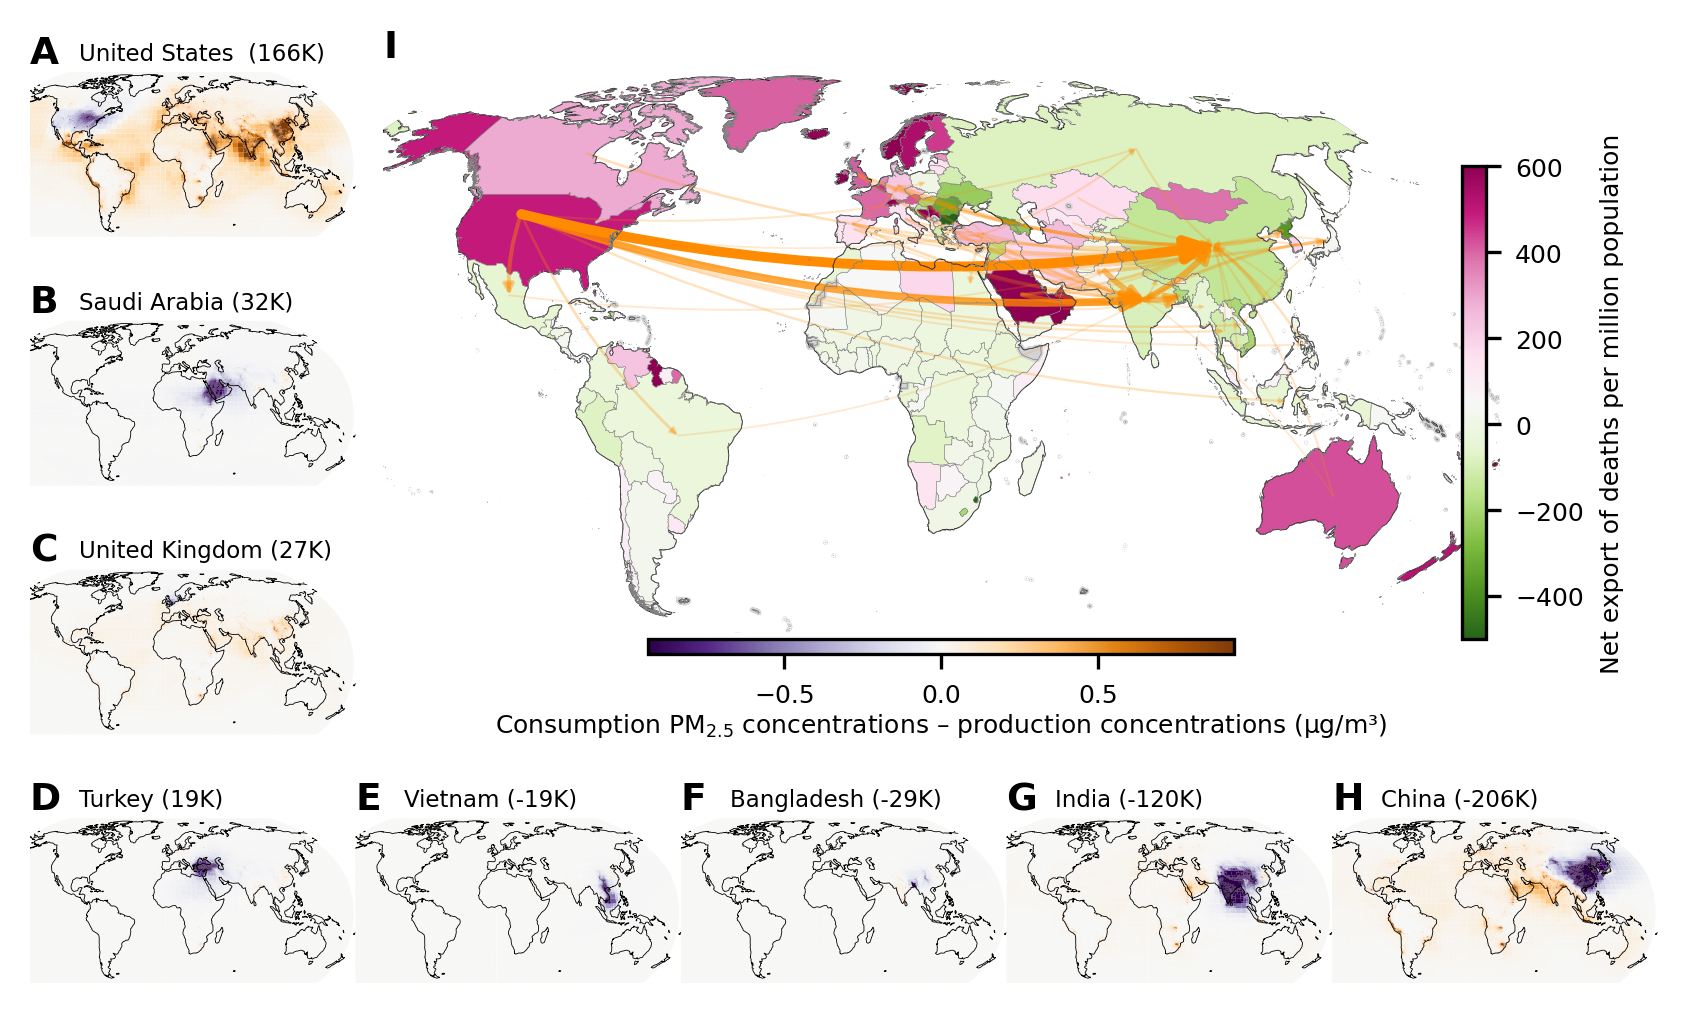

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import string
import matplotlib as mpl
import cartopy.crs as ccrs

# Assuming you have defined G, df_shp_eora, wholeworld, layout, cutpt, diff, countries, edgevals elsewhere

plt.rcParams.update({'font.size': 6})
fig = plt.figure(figsize=(7, 4), dpi=300)
gs = fig.add_gridspec(4, 5)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

ax = fig.add_subplot(gs[0:3, 1:5], projection=ccrs.Robinson())

df_shp_eora.plot(linewidths=1, ax=ax, column="death_exports", cmap="PiYG_r", missing_kwds={
    "color": "lightgrey",
    "edgecolor": "lightgrey",
    "hatch": "/ / / /",
    "label": "Missing values",
}, legend_kwds={'fmt': "{:.2f}"})

df_shp_eora.boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')

ax.coastlines(linewidths=0.2)
ax.axis('off')
ax.set_title(f'I', loc='left', pad=0, fontsize=9, fontweight='bold')
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

mn = df_shp_eora.death_exports.min()
mx = df_shp_eora.death_exports.max()
norm = mpl.colors.Normalize(vmin=mn, vmax=mx)
n_cmap = mpl.cm.ScalarMappable(norm=norm, cmap="PiYG_r")
n_cmap.set_array([])
fig.colorbar(n_cmap, ax=ax, orientation='vertical', aspect=20, shrink=0.7,
             pad=-0.05,
             label="Net export of deaths per million population")

norm = mpl.colors.Normalize(vmin=-cutpt, vmax=cutpt)
n_cmap = mpl.cm.ScalarMappable(norm=norm, cmap="PuOr_r")
n_cmap.set_array([])
cb = fig.colorbar(n_cmap, ax=ax, orientation='horizontal', aspect=40, shrink=0.5,
                  pad=0.01)
cb.set_label(r"Consumption PM$_{2.5}$ concentrations – production concentrations (μg/m³)",
              labelpad=1)

linevals = edgevals**0.5 / 100

edges = nx.draw_networkx_edges(G, layout, node_size=0, connectionstyle='arc3, rad = 0.1',
                               arrowsize=list(linevals * 5),
                               width=linevals,
                               edge_color='darkorange',
                               ax=ax)

for i in range(G.number_of_edges()):
    edges[i].set_alpha(linevals[i]/linevals.max())

# # ---- Add manual legend for arrow widths ----
# import matplotlib.lines as mlines

# # Define example values to label
# example_vals = [np.percentile(edgevals, p) for p in [25, 50, 75]]
# line_handles = []

# for val in example_vals:
#     width = (val ** 0.5) / 100
#     line = mlines.Line2D([], [], color='darkorange', linewidth=width, label=f"{val:.0f}")
#     line_handles.append(line)

# legend_ax = fig.add_axes([0.78, 0.3, 0.1, 0.1])  # x, y, width, height in figure coords
# legend_ax.axis('off')
# legend_ax.legend(handles=line_handles, title="Deaths moved", loc='center left', frameon=False)


locs = [[0, 0], [1, 0], [2, 0], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4]]
for i, loc in enumerate(locs):
    print(i)
    ax = fig.add_subplot(gs[loc[0], loc[1]], projection=ccrs.Robinson())
    wholeworld.plot(linewidths=0, column=diff[:, i], ax=ax, vmin=-cutpt, vmax=cutpt, cmap="PuOr_r", legend=False)
    ax.coastlines(linewidths=0.2)
    ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=1.5, fontsize=9, fontweight='bold')
    ax.text(0.15, 1.07, f"{df_shp_eora[df_shp_eora['ADM0_A3']==countries[i]].NAME.values[0][:14]} ({str(int(df_shp_eora[df_shp_eora['ADM0_A3']==countries[i]].death_exports_tol.values[0]/1000))+'K'})",
            fontsize=5.5, transform=ax.transAxes)
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    ax.axis('off')

fig.subplots_adjust(wspace=-0.0, hspace=0.4)

# Save the figure as a PDF with 300 dpi
# plt.savefig('Fig1_EORA.pdf', dpi=300)
plt.savefig('First_review_plot/Fig1_EORA.jpg', dpi=300)
